### 2021 Spring "EE479: Scientific Computing & Data"
#### Yong-Hoon Kim, KAIST Electrical Engineering
#### Kutz 10.3 Spectral Method implementation
##### Writer: Yumin Song

###### 2021. 05. 25 revised                                                             

In this section, we will consider an algorithm which implements a spectral method solution technique. we begin by considering the general partial differential equation.

$$ \frac{\partial{u}}{\partial{t}}=Lu + N(u) $$

where L is a linear, constant coefficient operator, $ L = ad^2/dx^2 + bd/dx +c $ where a,b and c  are constants. 
The second term $N(u)$ includes the nonlinear and nonconstant coefficient terms.

And example of is  $N(u)=u^{3} + f(x)u + g(x)d^2u/dx^2  $. By applying a Fourier transform, the equation reduce to the system of differential equations.

$$ \frac{d\widehat{u}}{dt} = \alpha(k)\widehat{u} + \widehat{N(u)}   $$

This can be expressed

$$ \widehat{u_{t}} = \widehat{a\frac{d^{2}u}{dx^2} + b\frac{du}{dx} + cu  }  = -ak^2\widehat{u} +ikb\widehat{u} + c\widehat{u}    $$ 
$$  \alpha(k)  = -ak^2 +ikb + c  $$

The nonlinear terms are a bit more difficult to handle.

Consider the following examples

#### 1. $f(x)du/dx$

$\bullet$ determine $du/dx \rightarrow \widehat{du/dx} = ik\widehat{u}, du/dx = FFT^{-1}(ik\widehat{u})  $ 

$\bullet$ multiply by $f(x)\rightarrow f(x)du/dx   $ 

$\bullet$ Fourier transform $ FFT(f(x)du/dx) $

#### 2. $u^3$

$\bullet$ Fourier transform $ FFT(u^{3}) $

#### 3. $u^3d^2u/dx^2$

$\bullet$ determine $d^{2}u/dx^{2} \rightarrow \widehat{d^{2}u/dx^{2}} = (ik)^{2}\widehat{u}, d^{2}u/dx^{2} = FFT^{-1}(-k^{2}\widehat{u})  $ 

$\bullet$ multiply by $u^{3} \rightarrow u^{3}d^{2}u/dx^{2}   $ 

$\bullet$ Fourier transform $ FFT(u^{3}d^{2}u/dx^{2}) $

This systme can be stepped forward in time with any of the standard time-stepping.

We can apply this scheme to advection-diffusion equations spectrally.

Advection-diffusion equation explains advection according to time.

Advection-diffusion equation is as follows.

$$ w_{t} = \nu \triangledown^{2}w - [\psi,w]    $$

$$ w_{t} = \nu \triangledown^{2}w - \psi_{x}w_{y} + \psi_{y}w_{x}    $$

where $ \triangledown^{2}\psi = w $ . $ \psi $ is streamfunction and $ w $ is vorticity.

Fourier transform of this equation is 

$$  \widehat{w_{t}} = -\nu(K_{x}^2 + K_{y}^2) \widehat{w} - \widehat{ \psi_{x}w_{y}} + \widehat{\psi_{y}w_{x}}  $$ 


The inital condition and parameter is as follows. The time step is 0,2,4,6,8,10. The computational domain is $x \in [-10,10] $ and $y \in [-10,10] $. The diffusion parameter is $\nu = 0.001. $ The initial conditions are then defined as a stretched Gaussian of the form $ w(x,y,0) = exp(-0.25x^{2} - y^{2}) $.

The code implementation is as follows.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from  scipy.fft import fft , ifft, fft2, ifft2
from scipy.integrate import solve_ivp

tspan = np.linspace(0,10,6)
nu=0.001
Lx=20; Ly=20; nx=64; ny=64; N=nx*ny;

x2=np.linspace(-Lx/2,Lx/2,nx+1); x=x2[0:nx];
y2=np.linspace(-Ly/2,Ly/2,ny+1); y=y2[0:ny];
[X,Y]=np.meshgrid(x,y);
X = X.T
Y = Y.T
w=1*np.exp(-0.25*X**2-Y**2);

#plt.contourf(x, y, w)

The spc_rhs function describes the Fourier transformed differential equation.
The code will quickly and efficiently solve the advection-diffusion equations in two dimensions.

For solving PDE, we firstly solve the elliptic problem 

$$ \triangledown^{2}\psi = w_{0}   $$

Retransforming in both x and y reduces the streamfunction equation by using Fourier transform.

 $$  \widehat{\psi} = -\frac{\widehat{w}}{k_{x}^2+k_{y}^2} $$  
 
From that result, we can treat nonlinear term.

For calculate, 

$$  \widehat{w_{t}} = -\nu(k_{x}^2 + k_{y}^2) \widehat{w} - \widehat{ \psi_{x}w_{y}} + \widehat{\psi_{y}w_{x}}  $$ 

we can use Fourier transform, as explained above.


$\bullet$ determine $dw/dx \rightarrow \widehat{dw/dx} = ik\widehat{w}, dw/dx = FFT^{-1}(ik\widehat{w})  $ 

$  w_{x}  =  FFT^{-1}(ik_{x}\widehat{w})  $ 

$  w_{y}  =  FFT^{-1}(ik_{y}\widehat{w})  $ 
 
 
$\bullet$ multiply by $f(x)\rightarrow f(x)dw/dx   $  using

$  \psi_{x}  =  FFT^{-1}(ik_{x}\widehat{\psi})  $  

$  \psi_{y}  =  FFT^{-1}(ik_{y}\widehat{\psi})  $ 

to make $  \psi_{x}w_{y} + \psi_{y}w_{x}    $


$\bullet$ Fourier transform $ FFT(f(x)du/dx) $

$FFT( \psi_{x}w_{y} + \psi_{y}w_{x}  )$

Follow these procedures, we can calculate PDE using FFT.

For time stepping we use scipy.solve_ivp which use Runge-Kutta method for solving ODEs.

C:\Users\song\anaconda3\lib\site-packages\numpy\core\_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


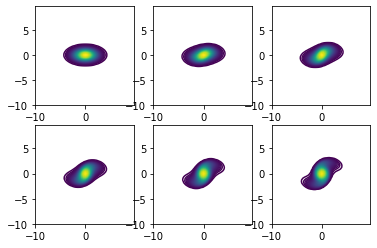

In [2]:
kx = np.zeros(nx)
for i in range(int(nx/2-1)+1):
    kx[i] = i
    kx[int(nx/2-1)+i+1] = -int(nx/2-1)+i-1
kx = kx* 2*np.pi/Lx
kx[0] = 10**(-6)
ky = np.zeros(ny)
for i in range(int(ny/2-1)+1):
    ky[i] = i
    ky[int(ny/2-1)+i+1] = -int(ny/2-1)+i-1
ky = ky* 2*np.pi/Ly
ky[0] = 10**(-6)
KX = np.zeros((64,64))
[KX,KY]=np.meshgrid(kx,ky);
KX = KX.T
KY = KY.T
K=KX**2+KY**2;

wt =fft2(w)
wt2 = wt.real
wt2 = wt2.reshape((len(wt)*len(wt)))

def spc_rhs(t,wt2):
    wtt = wt2.reshape(len(wt)*len(wt),1,order='F')
    wtt = wt2.reshape(64,64)
    
    psit = -wtt/K
    
    psix = (ifft2(1j*KX*psit)).real
    psiy = (ifft2(1j*KY*psit)).real 
    
    wx = (ifft2(1j*KX*wtt)).real
    wy = (ifft2(1j*KY*wtt)).real
    rhs = -nu*K*wtt+fft2(wx*psiy-wy*psix)
    rhs =  rhs.reshape(N)
    return rhs

sol = solve_ivp (spc_rhs,[0,10], wt2, t_eval=[0, 2, 4, 6, 8,10] )

T = sol.t
F = sol.y

levels = np.linspace(0.01,1,100)
for j in range(len(tspan)):
    plt.subplot(2,3,j+1)
    wf = ifft2(F[:,j].reshape(nx,ny)).real
    CS = plt.contour(X, Y, wf, levels)   # set levels automatically
  #  plt.title(j)
   # plt.colorbar()

The code results show the behavior of the vorticity. 
The stretched Gaussian is seen to rotate while advecting and diffusing vorticity as times goes on(0s,2s,4s,6s,8s,10s)..